In [2]:
#pip3 install torch torchvision torchaudio #installing torch and et.al.

In [3]:
#seeing if it was correctly installed in my venv

#!pip show torch
#!pip show torchvision
#!pip show torchaudio

In [4]:
# loading packages:

import numpy as np
import matplotlib.pyplot as plt

# loading Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [5]:
#checking if the GPU is enabled:

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [6]:
device = torch.device("mps")  #setting my GPU as the device variable

In [7]:
pwd()

'/Users/carolinabernal/Documents/DiplomadoExercises/alexnet/BernalRodriguez_Carolina/AlexNet_PyTorch'

In [8]:
#setting a working directory

import os

cd = '/Users/carolinabernal/Documents/DiplomadoExercises/alexnet/BernalRodriguez_Carolina/AlexNet_PyTorch'
path = cd

In [9]:
#setting my batchsize, I'm going with a little batch as I don't have a huge ram (16gb)

locBatchSize = 64
# locBatchSize = 4096

transform = transforms.Compose([
    transforms.Resize(224),  # AlexNet was trained with 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize the data.

#loading data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=locBatchSize, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=locBatchSize, shuffle=False, num_workers=2)

# order is important ! 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


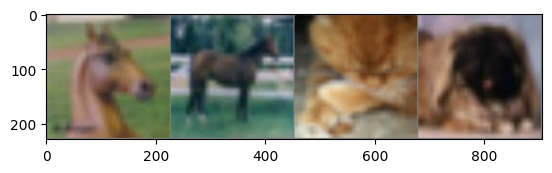

 horse || horse || cat || dog


In [10]:
#showing some sample images

def imageshow(image):
   # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

#pulling a sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))

In [11]:
images[1].shape #checking images are the same sizes which AlexNet was trined

#the zero entry of this vector also defines the entry of the first convolutional layer

torch.Size([3, 224, 224])

In [12]:
#defining my own AlexNet model


class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.cn1 = nn.Conv2d(3, 96, kernel_size = 11, padding = 2, stride = 4)
        self.cn2 = nn.Conv2d(96, 256, kernel_size = 5, padding = 2, stride = 1)
        self.cn3 = nn.Conv2d(256, 384, kernel_size = 3, padding = 1, stride = 1)
        self.cn4 = nn.Conv2d(384, 384, kernel_size = 3, padding = 1, stride = 1)
        self.cn5 = nn.Conv2d(384, 256, kernel_size = 3, padding = 1, stride = 1)


        self.fc1 = nn.Linear(6*6*256, 4096)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = F.max_pool2d(x, kernel_size = 3, stride=2)
        x = F.relu(self.cn2(x))
        x = F.max_pool2d(x, kernel_size = 3, stride=2)
        x = F.relu(self.cn3(x))
        x = F.relu(self.cn4(x))
        x = F.relu(self.cn5(x))
        x = F.max_pool2d(x, kernel_size = 3, stride=2)

        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    

In [13]:
#settinf the model
model = AlexNet().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

AlexNet(
  (cn1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (cn2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (cn3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cn4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cn5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)


In [14]:
#setting the training:

num_epochs = 20
history_new = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}

for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    
    running_loss = 0.0
    correct = 0
    total= 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # Ensure labels are long type
        labels = labels.long()

        loss = criterion(outputs, labels) # Corrected order: outputs, labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 *  correct / total
    train_loss = running_loss / len(trainloader)


    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradients during validation
        for i, data in enumerate(testloader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) # get the prediction

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct_val += (predicted == labels).sum().item() # count correct predictions
            total_val += labels.size(0)


    val_acc = 100 *  correct_val / total_val
    val_loss /= len(testloader)

    history_new["val_loss"].append(val_loss)
    history_new["val_acc"].append(val_acc)
    history_new["loss"].append(train_loss)
    history_new["acc"].append(train_acc)

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

print('Finished Training')

Epoch [1/20], Loss: 2.2969, Accuracy: 11.74%
Epoch [2/20], Loss: 1.6175, Accuracy: 19.76%
Epoch [3/20], Loss: 1.3504, Accuracy: 37.21%
Epoch [4/20], Loss: 1.3190, Accuracy: 44.47%
Epoch [5/20], Loss: 1.1009, Accuracy: 49.58%
Epoch [6/20], Loss: 1.1522, Accuracy: 53.80%
Epoch [7/20], Loss: 1.2300, Accuracy: 58.00%
Epoch [8/20], Loss: 1.0196, Accuracy: 61.52%
Epoch [9/20], Loss: 0.8218, Accuracy: 65.42%
Epoch [10/20], Loss: 0.7776, Accuracy: 68.92%
Epoch [11/20], Loss: 1.0306, Accuracy: 71.63%
Epoch [12/20], Loss: 0.9408, Accuracy: 74.89%
Epoch [13/20], Loss: 1.0432, Accuracy: 77.79%
Epoch [14/20], Loss: 1.0249, Accuracy: 81.16%
Epoch [15/20], Loss: 0.8457, Accuracy: 84.43%
Epoch [16/20], Loss: 0.6578, Accuracy: 87.93%
Epoch [17/20], Loss: 0.7642, Accuracy: 90.82%
Epoch [18/20], Loss: 1.2038, Accuracy: 93.85%
Epoch [19/20], Loss: 1.3959, Accuracy: 95.58%
Epoch [20/20], Loss: 1.1862, Accuracy: 96.69%
Finished Training


/var/folders/hr/yrdz47796ml5sfbpmg4kmttr0000gn/T/ipykernel_50303/1088464232.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
/var/folders/hr/yrdz47796ml5sfbpmg4kmttr0000gn/T/ipykernel_50303/1088464232.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')


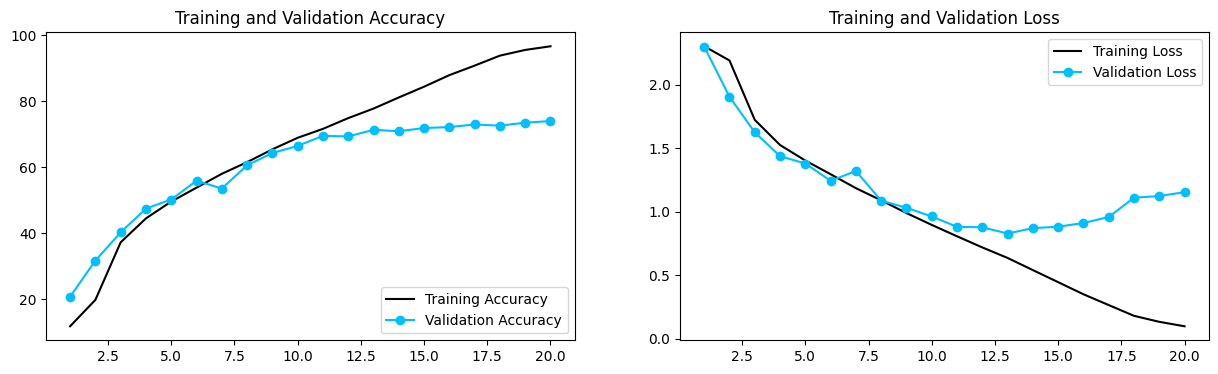

In [15]:
# Plot Training History (Optional but very useful)
acc = history_new['acc']
val_acc = history_new['val_acc']

loss = history_new['loss']
val_loss = history_new['val_loss']

epochs_range = range(1, 20+1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
plt.plot(epochs_range, val_acc, '-o' ,label='Validation Accuracy', color = 'deepskyblue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')
plt.plot(epochs_range, val_loss, '-o' ,label='Validation Loss', color = 'deepskyblue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('alexNet_Torch.jpg')

plt.show()

In [16]:
# 7. Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 74.00 %


In [18]:
# 8. Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 83.93 %
Accuracy of car   : 80.00 %
Accuracy of bird  : 68.35 %
Accuracy of cat   : 54.79 %
Accuracy of deer  : 78.18 %
Accuracy of dog   : 64.41 %
Accuracy of frog  : 82.14 %
Accuracy of horse : 68.75 %
Accuracy of ship  : 81.03 %
Accuracy of truck : 78.21 %


In [17]:
pwd()

'/Users/carolinabernal/Documents/DiplomadoExercises/alexnet/BernalRodriguez_Carolina/AlexNet_PyTorch'

In [18]:
torch.save(model, "./alexNet.pt")
torch.save(model, "./alexNet.pth")